In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

def print_warn(*args):
    printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{' '.join(map(str, args))}</font></code>")

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green', 'rpp_bad': 'yellow'}
local_planner_symbol = {'dwb': 'o', 'rpp': '^', 'teb': 'x', 'rpp_bad': 's'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [29]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
#     results_real_info = yaml.safe_load(results_real_info_file)
# df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]

# df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
#     results_gen_info = yaml.safe_load(results_gen_info_file)

# df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_relative_translation_error_mean': 'relative_translation_error',
    'collisionless_localization_update_relative_rotation_error_mean': 'relative_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
    'localization_node': 'localization',
    'local_planner_node': 'local_planner',
    'global_planner_node': 'global_planner',
})
results_info['run_parameter_names'] = [s.replace('_node', '') for s in results_info['run_parameter_names']]
# results_info = results_gen_info
# results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# only consider real localization
df = df[df.localization != 'localization_generator']

# only consider amcl_alpha_factor if 0.0, 0.5, 1.0, or 2.0
# df = df[df.amcl_alpha_factor == 1.0]
df = df[df.amcl_alpha_factor.isin([0.0, 0.5, 1.0, 2.0])].copy()

# turn odometry_error into beta..4
results_info['run_parameter_names'] += ['beta', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df['beta'] = df['beta_1']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
df['collisionless_failure_rate'] = (1 - df['success_rate']) & (1 - df['collision_rate'])

metrics += ['collisionless_failure_rate']
metrics_and_versions += ['collisionless_failure_rate']

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'std_trajectory_length'] = group_df.trajectory_length.std()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'var_trajectory_length'] = group_df.trajectory_length.var()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'mean_trajectory_length'] = group_df.trajectory_length.mean()
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'median_trajectory_length'] = group_df.trajectory_length.median()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
df['norm_trajectory_length_std'] = df.trajectory_length / df.min_trajectory_length / df.std_trajectory_length
df['norm_trajectory_length_mean'] = df.trajectory_length / df.mean_trajectory_length
df['norm_trajectory_length_median'] = df.trajectory_length / df.median_trajectory_length
metrics += ['norm_trajectory_length']
metrics += ['min_trajectory_length']
metrics += ['mean_trajectory_length']
metrics += ['median_trajectory_length']
metrics += ['norm_trajectory_length_std']
metrics += ['norm_trajectory_length_mean']
metrics += ['norm_trajectory_length_median']
metrics_and_versions += ['norm_trajectory_length']
metrics_and_versions += ['mean_trajectory_length']
metrics_and_versions += ['median_trajectory_length']
metrics_and_versions += ['norm_trajectory_length_std']
metrics_and_versions += ['norm_trajectory_length_mean']
metrics_and_versions += ['norm_trajectory_length_median']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    12004

## Run Parameters

    amcl_alpha_factor                                                      [0.0, 0.5, 1.0, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner                                                         ['navfn', 'smac']

    local_planner                                                          ['dwb', 'rpp', 'teb']

    localization                                                           ['amcl']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['hunter', 'turtle']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

    run_duplicate_index                                                    [nan, 1.0, 2.0]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.0, 0.02, 0.05, 0.1]

    beta_4                                                                 [0.0]

    beta                                                                   [0.0, 0.02, 0.05, 0.1]

## Metrics

    collision_rate                                                         min:          0             avg:    0.04465             max:          1             nan:          0

    collision_time                                                         min:      7.801             avg:      85.35             max:      432.1             nan:  1.147e+04

    collision_rate_version                                                 [3]

    clearance                                                              min:        nan             avg:        nan             max:        nan             nan:    1.2e+04

    clearance_version                                                      [1]

    minimum_clearance                                                      min:          0             avg:     0.8311             max:      5.819             nan:          0

    average_clearance                                                      min:      1.935             avg:      5.002             max:      12.42             nan:          0

    median_clearance                                                       min:     0.2977             avg:      3.993             max:      11.77             nan:          0

    maximum_clearance                                                      min:      5.448             avg:      22.29             max:      29.82             nan:          0

    trajectory_length                                                      min:          0             avg:      16.13             max:      133.9             nan:          1

    trajectory_length_version                                              [1]

    execution_time                                                         min:      0.069             avg:      68.09             max:      648.1             nan:          1

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.7474             max:          1             nan:          0

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:  2.438e-17             avg:    0.06014             max:      6.012             nan:       2160

    odometry_error_alpha_1_std                                             min:          0             avg:    0.06958             max:      28.09             nan:       2160

    odometry_error_alpha_2_mean                                            min:  4.519e-18             avg:    0.07306             max:      12.15             nan:       2160

    odometry_error_alpha_2_std                                             min:          0             avg:     0.1373             max:      33.95             nan:       2160

    odometry_error_alpha_3_mean                                            min:   8.68e-18             avg:    0.06371             max:     0.9427             nan:       2160

    odometry_error_alpha_3_std                                             min:          0             avg:    0.01273             max:      1.442             nan:       2160

    odometry_error_alpha_4_mean                                            min:  9.598e-18             avg:     0.2848             max:      1.477             nan:       2160

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2395             max:      1.723             nan:       2160

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:  0.0009009             avg:    0.09381             max:      2.718             nan:       2162

    localization_update_absolute_translation_error_std                     min:          0             avg:     0.0451             max:      3.722             nan:       2162

    localization_update_absolute_rotation_error_mean                       min:  0.0003113             avg:    0.02284             max:      1.495             nan:       2162

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.03822             max:      1.348             nan:       2162

    localization_update_relative_translation_error_mean                    min:  0.0005164             avg:   0.009943             max:     0.2224             nan:       2162

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01012             max:      1.124             nan:       2162

    localization_update_relative_rotation_error_mean                       min:  0.0001568             avg:    0.01092             max:     0.4347             nan:       2162

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.03901             max:     0.9476             nan:       2162

    localization_update_normalized_relative_translation_error_mean         min:   0.001581             avg:    0.05883             max:      2.573             nan:       2162

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.06709             max:      9.121             nan:       2162

    localization_update_normalized_relative_rotation_error_mean            min:  0.0006716             avg:    0.08042             max:      4.263             nan:       2184

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:     0.2057             max:      12.26             nan:       2184

    localization_update_error_version                                      [4]

    absolute_translation_error                                             min:  0.0009009             avg:    0.09185             max:     0.5609             nan:       2162

    collisionless_localization_update_absolute_translation_error_std       min:          0             avg:    0.04299             max:     0.4036             nan:       2162

    absolute_rotation_error                                                min:  0.0003113             avg:    0.02079             max:     0.2085             nan:       2162

    collisionless_localization_update_absolute_rotation_error_std          min:          0             avg:    0.03455             max:     0.7018             nan:       2162

    relative_translation_error                                             min:  0.0005164             avg:   0.009885             max:     0.2224             nan:       2162

    collisionless_localization_update_relative_translation_error_std       min:          0             avg:   0.009888             max:      1.124             nan:       2162

    relative_rotation_error                                                min:  0.0001568             avg:    0.01014             max:     0.3534             nan:       2162

    collisionless_localization_update_relative_rotation_error_std          min:          0             avg:    0.03703             max:     0.9476             nan:       2162

    normalized_relative_translation_error                                  min:   0.001581             avg:     0.0558             max:     0.3278             nan:       2162

    collisionless_localization_update_normalized_relative_translation_error_std min:          0             avg:    0.05919             max:     0.8927             nan:       2162

    normalized_relative_rotation_error                                     min:  0.0006716             avg:     0.2205             max:      13.03             nan:       2162

    collisionless_localization_update_normalized_relative_rotation_error_std min:          0             avg:      1.116             max:      46.61             nan:       2162

    collisionless_localization_update_error_version                        [1]

    localization_update_rate                                               min:     0.2364             avg:     0.9086             max:       32.4             nan:       2160

    localization_update_rate_std                                           min:          0             avg:     0.3652             max:      14.34             nan:       2160

    localization_update_rate_version                                       [1]

    average_translation_velocity                                           min:  5.858e-05             avg:     0.2475             max:       0.35             nan:       2063

    average_rotation_velocity                                              min:   2.57e-05             avg:     0.1367             max:     0.9651             nan:       2063

    translation_rotation_product                                           min:  1.505e-09             avg:    0.02778             max:     0.1542             nan:       2063

    average_translation_acceleration                                       min:   8.57e-11             avg:     0.1188             max:     0.6255             nan:       2068

    average_rotation_acceleration                                          min:  3.719e-11             avg:     0.1787             max:     0.9988             nan:       2068

    translation_rotation_acceleration_product                              min:  4.953e-21             avg:    0.03043             max:     0.3641             nan:       2068

    average_velocity_atan                                                  min:    0.01885             avg:     0.3628             max:      1.328             nan:       2063

    motion_characteristics_version                                         [4]

    controller_cpu_time                                                    min:        0.5             avg:      52.72             max:       1031             nan:          0

    planner_cpu_time                                                       min:       0.32             avg:      16.71             max:        395             nan:          0

    system_cpu_time                                                        min:       2.13             avg:      76.94             max:       1303             nan:          0

    controller_max_memory                                                  min:      21.45             avg:      40.85             max:      78.79             nan:          0

    planner_max_memory                                                     min:      22.23             avg:      166.3             max:  3.116e+04             nan:          0

    system_max_memory                                                      min:      132.2             avg:      327.7             max:  3.134e+04             nan:          0

    cpu_time_and_max_memory_version                                        [1]

    fixed_rpp                                                              min:          1             avg:          1             max:          1             nan:       9219

    beta_1                                                                 min:          0             avg:    0.05452             max:        0.1             nan:          0

    collisionless_failure_rate                                             min:          0             avg:     0.2079             max:          1             nan:          0

    average_velocity                                                       min:          0             avg:      0.185             max:     0.2681             nan:          1

    norm_trajectory_length                                                 min:          0             avg:     0.8615             max:      10.69             nan:          1

    mean_trajectory_length                                                 min:     0.9084             avg:      21.49             max:      100.8             nan:          0

    median_trajectory_length                                               min:      0.879             avg:      21.28             max:      100.5             nan:          0

    norm_trajectory_length_std                                             min:          0             avg:      4.118             max:      14.72             nan:          1

    norm_trajectory_length_mean                                            min:          0             avg:     0.8075             max:      8.015             nan:          1

    norm_trajectory_length_median                                          min:          0             avg:     0.8277             max:      9.641             nan:          1

    norm_execution_time                                                    min:  0.0003575             avg:     0.9401             max:      12.74             nan:          1

In [53]:
print('number of runs')
print('turtle', len(df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)]))
print('hunter', len(df[df.robot_model == 'hunter']))
print('turtle + hunter', len(df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)]) + len(df[df.robot_model == 'hunter']))

number of runs
turtle 11062
hunter 469
turtle + hunter 11531


In [54]:
print('execution time [hours]')
print('turtle', df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)].execution_time.sum()/60/60)
print('hunter', df[df.robot_model == 'hunter'].execution_time.sum()/60/60)
print('turtle + hunter', df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)].execution_time.sum()/60/60 + df[df.robot_model == 'hunter'].execution_time.sum()/60/60)

execution time [hours]
turtle 202.0276533333333
hunter 10.468330277777778
turtle + hunter 212.49598361111106


In [55]:
print('execution time [days]')
print('turtle', df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)].execution_time.sum()/60/60/24)
print('hunter', df[df.robot_model == 'hunter'].execution_time.sum()/60/60/24)
print('turtle + hunter', df[(df.robot_model == 'turtle') & (df.max_steering_angle_deg == 90)].execution_time.sum()/60/60/24 + df[df.robot_model == 'hunter'].execution_time.sum()/60/60/24)

execution time [days]
turtle 8.417818888888887
hunter 0.4361804282407407
turtle + hunter 8.853999317129627


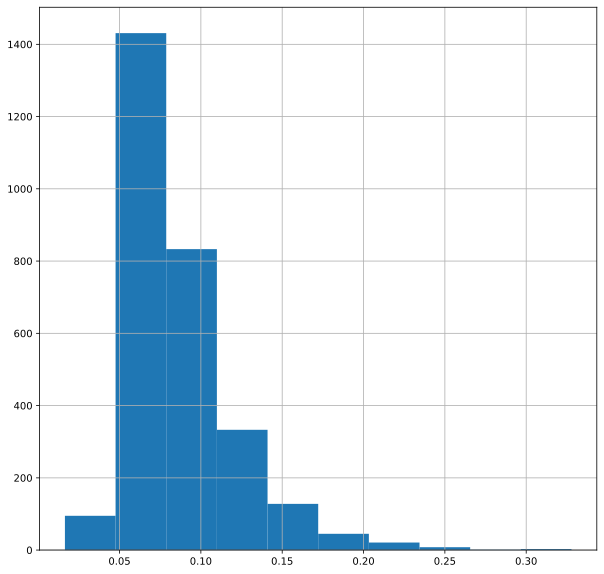

In [9]:
df[(df.beta == .1) & (df.max_steering_angle_deg == 90.0)].normalized_relative_translation_error.hist()
plt.show()

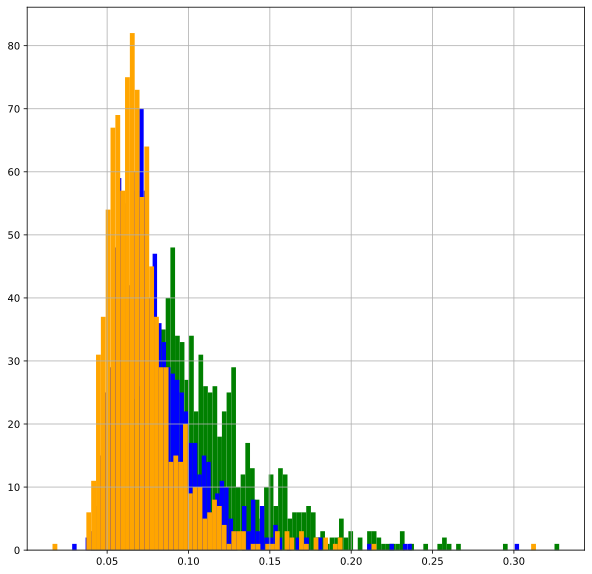

In [10]:

df[(df.beta == .1) & (df.max_steering_angle_deg == 90.0) & (df.local_planner == 'teb')].normalized_relative_translation_error.hist(bins=100, color=local_planner_color['teb'])
df[(df.beta == .1) & (df.max_steering_angle_deg == 90.0) & (df.local_planner == 'dwb')].normalized_relative_translation_error.hist(bins=100, color=local_planner_color['dwb'])
df[(df.beta == .1) & (df.max_steering_angle_deg == 90.0) & (df.local_planner == 'rpp')].normalized_relative_translation_error.hist(bins=100, color=local_planner_color['rpp'])
plt.show()

In [11]:
printmd("## Overall performance values by robot model, local planner component, kinematic constraints, and localization component")
printmd("### Considering all runs (sorted by collisionless success rate)")
df.groupby(['robot_model', 'local_planner', 'max_steering_angle_deg', 'localization'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('success_rate', 'mean'), ascending=False)

## Overall performance values by robot model, local planner component, kinematic constraints, and localization component

### Considering all runs (sorted by collisionless success rate)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                      mean count           mean count             mean count                   mean count                mean count
robot_model local_planner max_steering_angle_deg localization                                                                                                                      
turtle      teb           40.000                 amcl                0.786   234          0.103   234            0.217   234                  1.044   234               1.155   234
                          90.000                 amcl                0.774  3342          0.068  3342            0.201  3342                  0.916  3342               0.956  3342
            rpp           90.000                 amcl                0.769  3852          0.008  3852            0.182  3851                  0.808  3851               0.865  3851
            dwb           90.000                 amcl                0.768  3868          0.008  3868            0.176  3868                  0.815  3868               0.910  3868
            teb           20.000                 amcl                0.665   239          0.079   239            0.199   239                  1.403   239               1.705   239
hunter      teb           20.000                 amcl                0.258   233          0.403   233            0.154   233                  1.049   233               1.333   233
                          40.000                 amcl                0.208   236          0.475   236            0.153   236                  0.807   236               1.057   236

In [12]:
printmd("### Only considering successful runs (sorted by norm trajectory length)")
df[df.success_rate == 1].groupby(['robot_model', 'local_planner', 'max_steering_angle_deg', 'localization'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('norm_trajectory_length', 'mean'), ascending=True)

### Only considering successful runs (sorted by norm trajectory length)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                      mean count           mean count             mean count                   mean count                mean count
robot_model local_planner max_steering_angle_deg localization                                                                                                                      
turtle      rpp           90.000                 amcl                1.000  2961          0.000  2961            0.229  2961                  1.027  2961               1.098  2961
            dwb           90.000                 amcl                1.000  2971          0.000  2971            0.221  2971                  1.037  2971               1.159  2971
            teb           90.000                 amcl                1.000  2588          0.000  2588            0.232  2588                  1.079  2588               1.119  2588
                          40.000                 amcl                1.000   184          0.000   184            0.231   184                  1.155   184               1.230   184
hunter      teb           40.000                 amcl                1.000    49          0.000    49            0.215    49                  1.369    49               1.554    49
turtle      teb           20.000                 amcl                1.000   159          0.000   159            0.224   159                  1.625   159               1.836   159
hunter      teb           20.000                 amcl                1.000    60          0.000    60            0.222    60                  1.700    60               1.881    60

In [13]:
printmd("### Only considering failed runs (sorted by collision rate)")
df[df.success_rate == 0].groupby(['robot_model', 'local_planner', 'max_steering_angle_deg', 'localization'])[["success_rate", "collision_rate", "average_velocity", "norm_trajectory_length", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('collision_rate', 'mean'), ascending=True)

### Only considering failed runs (sorted by collision rate)

success_rate       collision_rate       average_velocity       norm_trajectory_length       norm_execution_time      
                                                                      mean count           mean count             mean count                   mean count                mean count
robot_model local_planner max_steering_angle_deg localization                                                                                                                      
turtle      rpp           90.000                 amcl                0.000   891          0.033   891            0.024   890                  0.081   890               0.088   890
            dwb           90.000                 amcl                0.000   897          0.033   897            0.024   897                  0.079   897               0.087   897
            teb           20.000                 amcl                0.000    80          0.237    80            0.150    80                  0.962    80               1.443    80
                          90.000                 amcl                0.000   754          0.302   754            0.093   754                  0.355   754               0.399   754
                          40.000                 amcl                0.000    50          0.480    50            0.168    50                  0.637    50               0.879    50
hunter      teb           20.000                 amcl                0.000   173          0.543   173            0.131   173                  0.822   173               1.143   173
                          40.000                 amcl                0.000   187          0.599   187            0.136   187                  0.660   187               0.926   187

In [14]:
def bar_plot(metric_name, selected_df, y_columns=['robot_model', 'local_planner', 'global_planner'], percentage=False, unit_symbol=None, higher_better=True, save_fig_name=None):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=higher_better)
    ax = (bar_df.sort_values(by=('mean'), ascending=higher_better)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, grid=True, legend=False)

    ax.set_axisbelow(True)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', ') + (f" [{unit_symbol}]" if unit_symbol else ""))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ',\n'))
    plt.gcf().set_size_inches([6, 2])
    if save_fig_name is not None:
        if not path.exists(path.dirname(save_fig_name)):
            os.makedirs(path.dirname(save_fig_name))
        fig = ax.get_figure()
        fig.savefig(save_fig_name, bbox_inches='tight')
    plt.show()

# Local Planner performance

## success rate

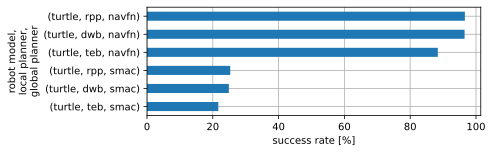

## collision_rate

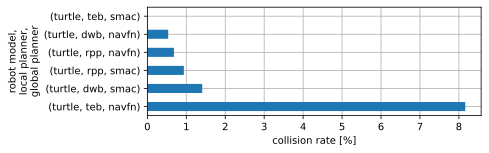

## norm_trajectory_length, only successful runs

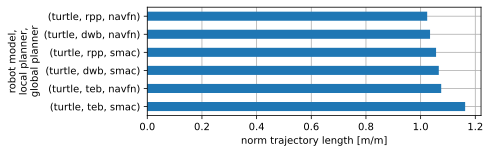

## norm_execution_time, only successful runs

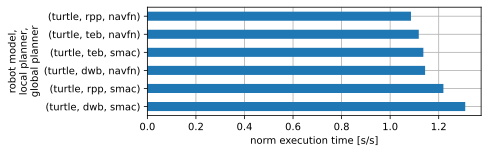

## average_clearance

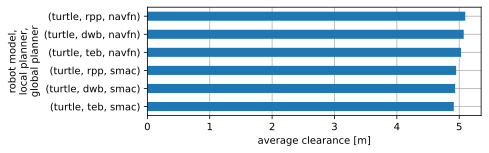

## average_clearance, only successful runs

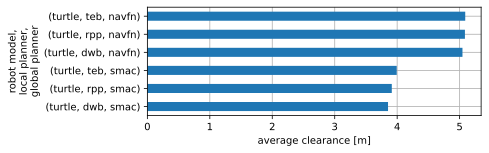

In [58]:
printmd("# Local Planner performance")

printmd("## success rate")
bar_plot(metric_name='success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=True, unit_symbol='%', save_fig_name="bar_plots/success-rate.pdf")

printmd("## collision_rate")
bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=False, unit_symbol='%', save_fig_name="bar_plots/collision-rate.pdf")

printmd("## norm_trajectory_length, only successful runs")
bar_plot(metric_name='norm_trajectory_length', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m/m', save_fig_name="bar_plots/norm-trajectory-length--only-successful.pdf")

printmd("## norm_execution_time, only successful runs")
bar_plot(metric_name='norm_execution_time', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='s/s', save_fig_name="bar_plots/norm-execution-time--only-successful.pdf")

printmd("## average_clearance")
bar_plot(metric_name='average_clearance', selected_df=df[(df.max_steering_angle_deg == 90.0)], higher_better=True, unit_symbol='m', save_fig_name="bar_plots/average-clearance.pdf")

printmd("## average_clearance, only successful runs")
bar_plot(metric_name='average_clearance', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=True, unit_symbol='m', save_fig_name="bar_plots/average-clearance--only-successful.pdf")

# Localization performance

## absolute error

### absolute_translation_error

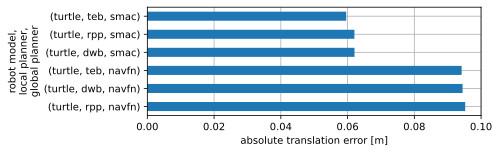

### absolute_translation_error rate, success rate == 1

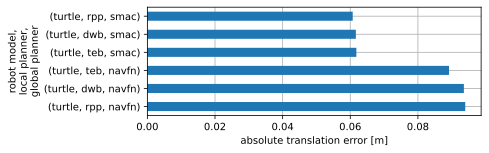

### absolute_rotation_error

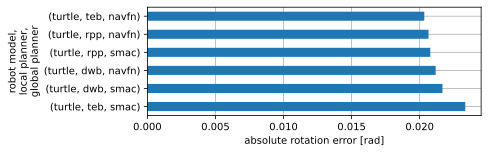

### absolute_rotation_error, success rate == 1

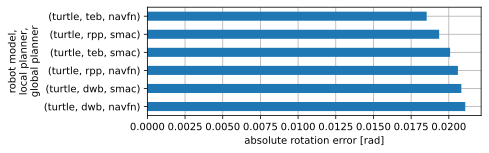

## relative error

### relative_translation_error

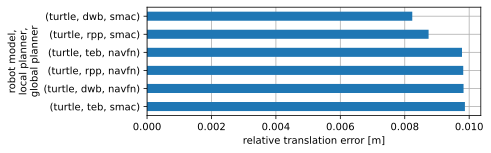

### relative_translation_error, success rate == 1

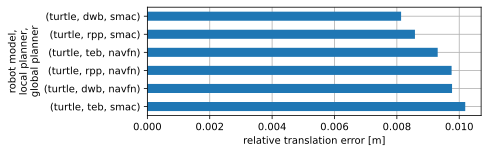

### relative_rotation_error

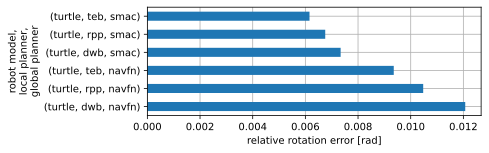

### relative_rotation_error, success rate == 1

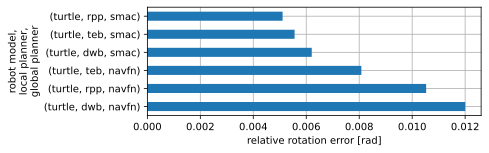

## normalized relative error

### normalized_relative_translation_error

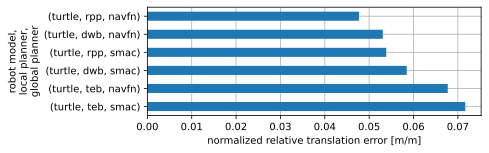

### normalized_relative_translation_error, success rate == 1

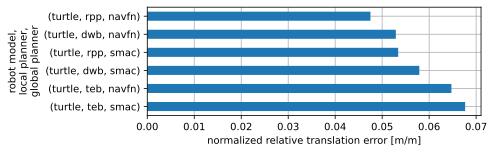

### normalized_relative_rotation_error

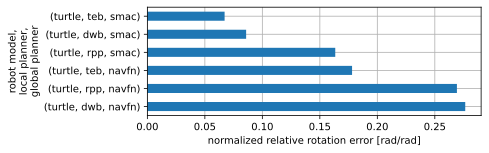

### normalized_relative_rotation_error, success rate == 1

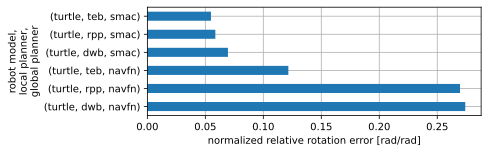

In [16]:
printmd("# Localization performance")


printmd("## absolute error")

printmd("### absolute_translation_error")
bar_plot(metric_name='absolute_translation_error', selected_df=df[(df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m', 
         save_fig_name="bar_plots/absolute-translation-error.pdf")

printmd("### absolute_translation_error rate, success rate == 1")
bar_plot(metric_name='absolute_translation_error', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m', 
         save_fig_name="bar_plots/absolute-translation-error--only-successful.pdf")

printmd("### absolute_rotation_error")
bar_plot(metric_name='absolute_rotation_error', selected_df=df[(df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='rad', 
         save_fig_name="bar_plots/absolute-rotation-error.pdf")

printmd("### absolute_rotation_error, success rate == 1")
bar_plot(metric_name='absolute_rotation_error', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='rad', 
         save_fig_name="bar_plots/absolute-rotation-error--only-successful.pdf")


printmd("## relative error")

printmd("### relative_translation_error")
bar_plot(metric_name='relative_translation_error', selected_df=df[(df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m', 
         save_fig_name="bar_plots/relative-translation-error.pdf")

printmd("### relative_translation_error, success rate == 1")
bar_plot(metric_name='relative_translation_error', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m', 
         save_fig_name="bar_plots/relative-translation-error--only-successful.pdf")

printmd("### relative_rotation_error")
bar_plot(metric_name='relative_rotation_error', selected_df=df[(df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='rad', 
         save_fig_name="bar_plots/relative-rotation-error.pdf")

printmd("### relative_rotation_error, success rate == 1")
bar_plot(metric_name='relative_rotation_error', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='rad', 
         save_fig_name="bar_plots/relative-rotation-error--only-successful.pdf")


printmd("## normalized relative error")

printmd("### normalized_relative_translation_error")
bar_plot(metric_name='normalized_relative_translation_error', selected_df=df[(df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m/m', 
         save_fig_name="bar_plots/normalized-relative-translation-error.pdf")

printmd("### normalized_relative_translation_error, success rate == 1")
bar_plot(metric_name='normalized_relative_translation_error', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='m/m', 
         save_fig_name="bar_plots/normalized-relative-translation-error--only-successful.pdf")

printmd("### normalized_relative_rotation_error")
bar_plot(metric_name='normalized_relative_rotation_error', selected_df=df[(df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='rad/rad', 
         save_fig_name="bar_plots/normalized-relative-rotation-error.pdf")

printmd("### normalized_relative_rotation_error, success rate == 1")
bar_plot(metric_name='normalized_relative_rotation_error', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='rad/rad', 
         save_fig_name="bar_plots/normalized-relative-rotation-error--only-successful.pdf")


In [17]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization in df.localization.unique():
            for local_planner in df.local_planner.unique():
                
                df_lr = selected_df[
                    (selected_df.localization == localization) & 
                    (selected_df.local_planner == local_planner) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range')[output_metric.name].agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g['count'] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g['mean'], f'{local_planner_symbol[local_planner]}-', fillstyle='none', mfc=None, label=f'{local_planner}', linewidth=1, color=local_planner_color[local_planner])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name)[output_metric.name].agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g['count'] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g['mean'], f'{local_planner_symbol[local_planner]}-', fillstyle='none', mfc=None, label=f'{local_planner}', linewidth=1, color=local_planner_color[local_planner])
                    max_y = max(max_y, df_lr_g['mean'].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


## Localization perf from system features

### absolute translation error

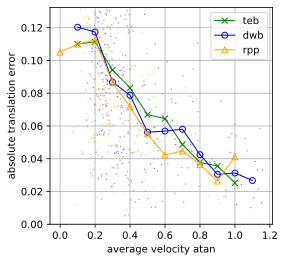

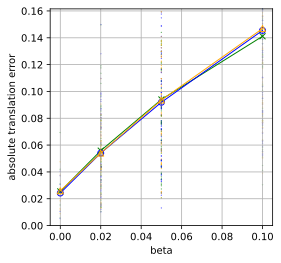

### absolute rotation error

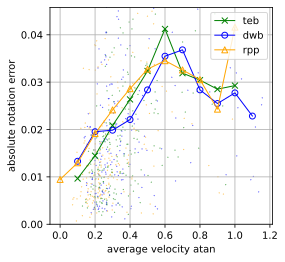

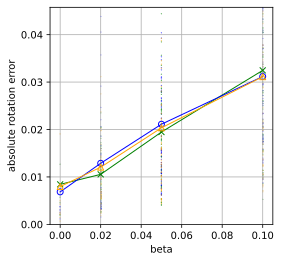

### relative translation error

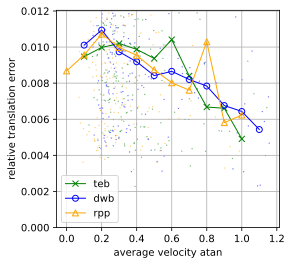

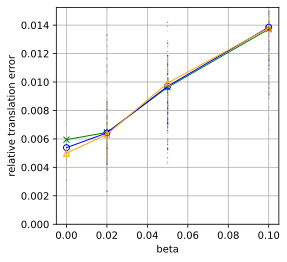

### relative rotation error

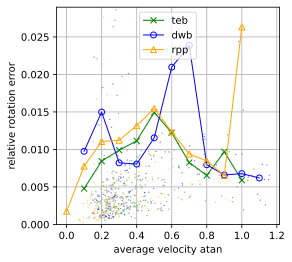

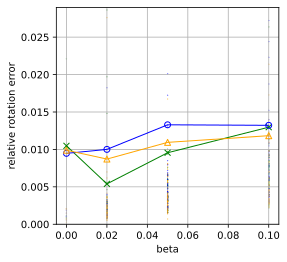

### normalized relative translation error

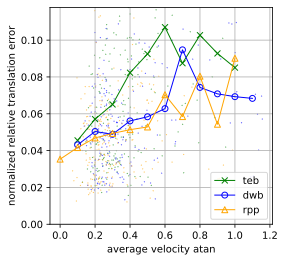

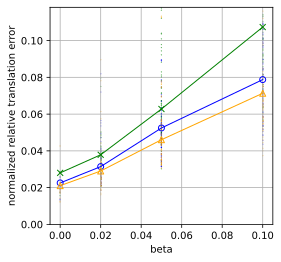

### normalized relative rotation error

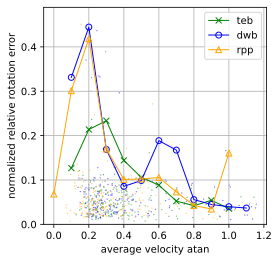

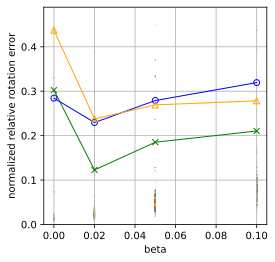

## Localization perf from own parameters

### absolute translation error

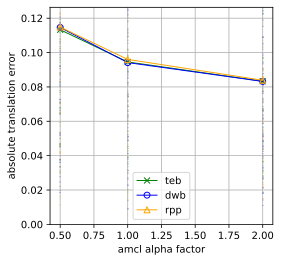

### absolute rotation error

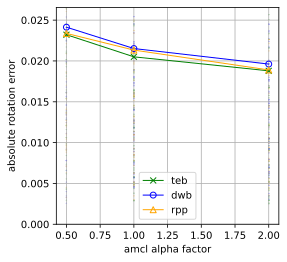

### relative translation error

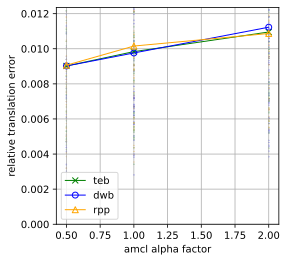

### relative rotation error

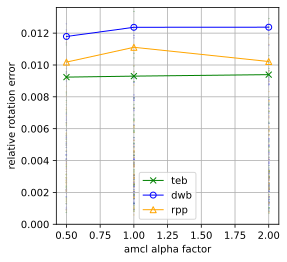

### normalized relative translation error

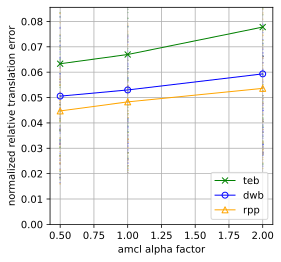

### normalized relative rotation error

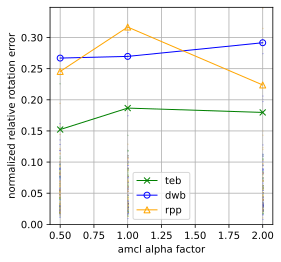

In [28]:
printmd("## Localization perf from system features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
#     [d.average_velocity, 0.02], 
#     [d.average_translation_velocity, 0.02], 
    [d.average_velocity_atan, 0.1],
    [d.beta, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.relative_translation_error,
    d.relative_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )


printmd("## Localization perf from own parameters")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl') & (df.amcl_alpha_factor != 0)].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.amcl_alpha_factor, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.relative_translation_error,
    d.relative_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )

In [19]:
# # printmd("## Localization perf from local planner perf, in different traj length buckets")

# l_min_max = [
#     [0, 10],
#     [10, 20],
#     [20, 30],
#     [30, 40],
#     [40, 50],
#     [50, 60],
#     [60, 70],
#     [70, 80],
#     [70, 1000],
# ]

# output_metrics = [
#     d.normalized_relative_translation_error,
#     d.normalized_relative_rotation_error,
# ]
    
# for output_metric in output_metrics:
#     printmd(f"### {output_metric.name.replace('_', ' ')}")
#     for l_min, l_max in l_min_max:
#         printmd(f"#### {l_min} <= df.trajectory_length < {l_max}")
#         d = df[(df.trajectory_length >= l_min) & (df.trajectory_length < l_max) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
#         min_bin_count = 10
#         input_metrics, bin_widths = zip(*[
#             [d.average_velocity_atan, 0.1],
#         ])
#         plot_in_out_metrics_bin_width_save(
#             output_metric=output_metric, 
#             input_metrics=input_metrics, 
#             bin_widths=bin_widths,
#             min_bin_count=min_bin_count,
#             selected_df=d,
#             out_dir="thesis_plots/localization",
#         )


In [20]:
# printmd("## avg vel and avg vel atan are similar")
# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
# input_metrics = [
#     d.average_translation_velocity,
#     d.average_rotation_velocity,
#     d.average_velocity_atan,
# ]
# bin_widths = [0.02, 0.05, 0.1]
# min_bin_count = 10
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_translation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_rotation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_velocity_atan, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )

In [21]:

# # print(df.goal_index)

# bin_widths = [None, None, None]
# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
# input_metrics = [
#     d.environment_name,
#     d.run_duplicate_index,
#     d.goal_index,
# ]

# plot_in_out_metrics_bin_width_save(
#     output_metric=d.minimum_clearance, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=10,
#     selected_df=d,
#     plot_all=False,
#     scatter=False,
#     out_dir="thesis_plots/local_planner",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=10,
#     selected_df=d,
#     plot_all=False,
#     scatter=False,
#     out_dir="thesis_plots/local_planner",
# )

In [22]:

# printmd("### norm trajectory length ← absolute translation error doesn't work because when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.01]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.absolute_translation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
    
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [23]:

# printmd("### norm trajectory length, trajectory length ← other localization error metrics")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.03]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.normalized_relative_rotation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [24]:


# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     min_bin_count = 10
#     d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl') & (df.environment_name == e)].copy()
#     bin_widths = [1, .1, .01]
#     input_metrics = [
#         d.maximum_clearance, 
#         d.average_clearance, 
#         d.minimum_clearance, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.average_velocity, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         min_y=0.0,
#         plot_all=False,
#         scatter=True,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


## Local Planning perf (also system features)

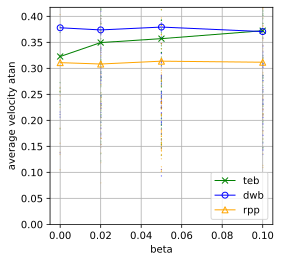

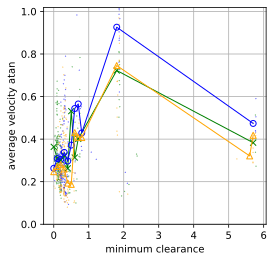

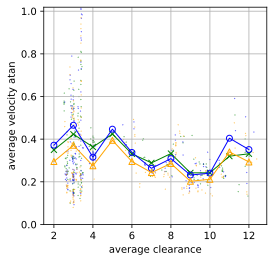

In [56]:

printmd("## Local Planning perf (also system features)")

min_bin_count = 10
d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta, None], 
#     [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity_atan, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)

## Local Planning perf (not system features)

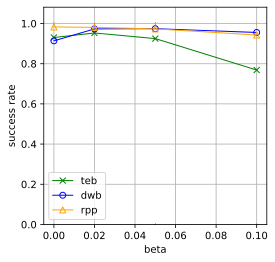

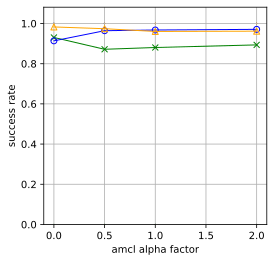

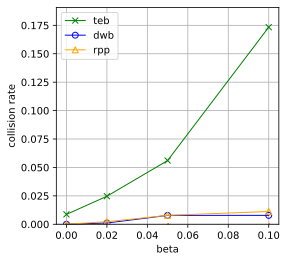

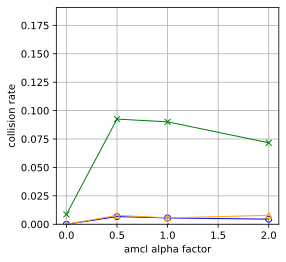

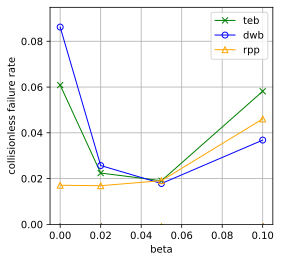

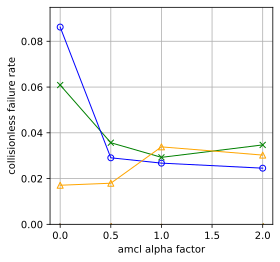

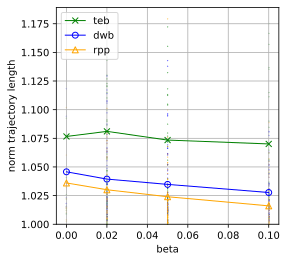

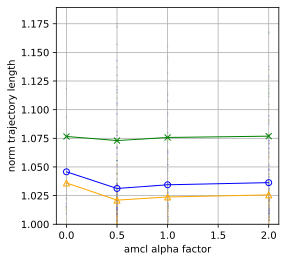

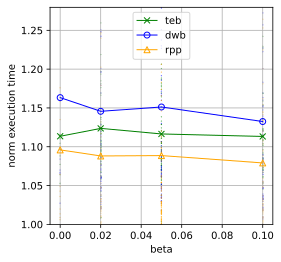

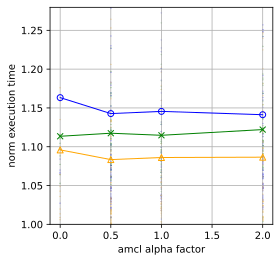

In [30]:
## plots_local_planner

printmd("## Local Planning perf (not system features)")

min_bin_count = 10

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta, None], 
    [d.amcl_alpha_factor, None],
#     [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.success_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.collision_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.collisionless_failure_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta, None], 
    [d.amcl_alpha_factor, None],
#     [d.minimum_clearance, .1],
#     [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_trajectory_length, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_execution_time, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)

## success_rate

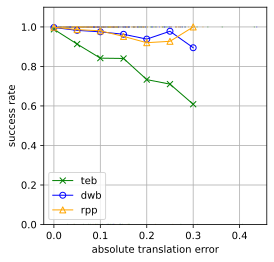

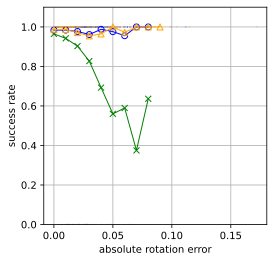

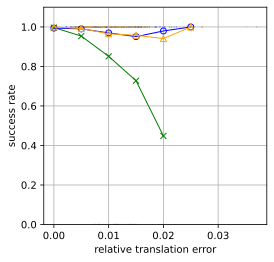

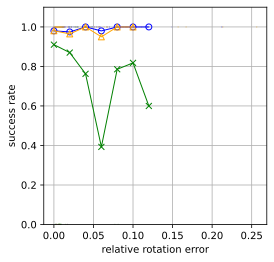

In [35]:
## plots_local_planner

min_bin_count = 10

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
#     [d.beta, None], 
#     [d.amcl_alpha_factor, None],
    [d.absolute_translation_error, 0.05],
    [d.absolute_rotation_error, 0.01],
    [d.relative_translation_error, 0.005],
    [d.relative_rotation_error, 0.02],
#     [d.normalized_relative_translation_error, 0.05],
#     [d.normalized_relative_rotation_error, 0.05],
])

printmd("## success_rate")
plot_in_out_metrics_bin_width_save(
    output_metric=d.success_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=0.0,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)


# beta 0.0

## success_rate

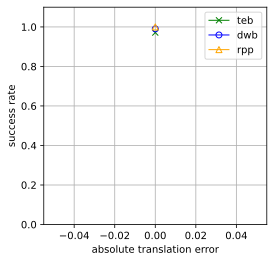

# beta 0.02

## success_rate

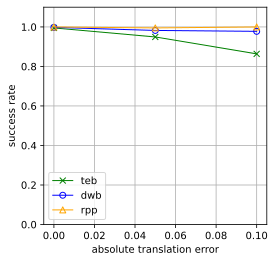

# beta 0.05

## success_rate

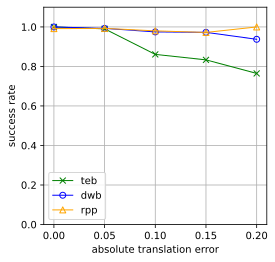

# beta 0.1

## success_rate

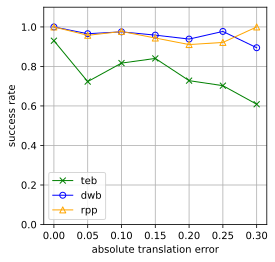

In [44]:
## plots_local_planner

min_bin_count = 10

for beta in sorted(df.beta.unique()):
    printmd("# beta", beta)
    d = df[(df.beta == beta) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
    input_metrics, bin_widths = zip(*[
    #     [d.beta, None], 
    #     [d.amcl_alpha_factor, None],
        [d.absolute_translation_error, 0.05],
#         [d.absolute_rotation_error, 0.01],
#         [d.relative_translation_error, 0.005],
#         [d.relative_rotation_error, 0.02],
    #     [d.normalized_relative_translation_error, 0.05],
    #     [d.normalized_relative_rotation_error, 0.05],
    ])

    printmd("## success_rate")
    plot_in_out_metrics_bin_width_save(
        output_metric=d.success_rate, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        min_y=0.0,
        plot_all=False,
        scatter=False,
        out_dir="thesis_plots/local_planner_by_beta",
    )


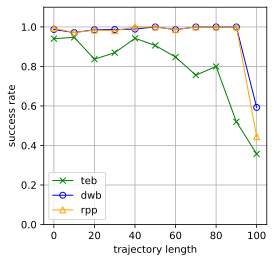

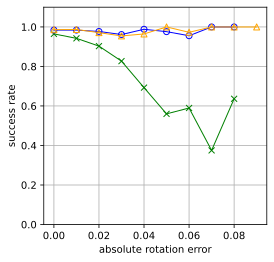

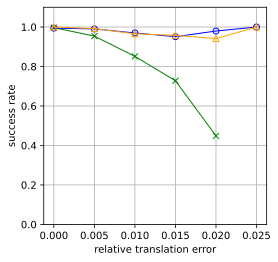

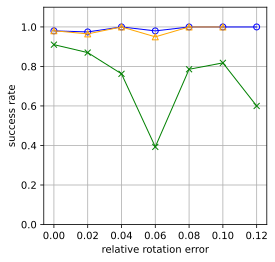

In [47]:
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
#     printmd("# beta", beta)
#     d = df[(df.beta == beta) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.trajectory_length, 10],
    [d.absolute_rotation_error, 0.01],
    [d.relative_translation_error, 0.005],
    [d.relative_rotation_error, 0.02],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.success_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=0.0,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)

# 0 <= df.trajectory_length < 10

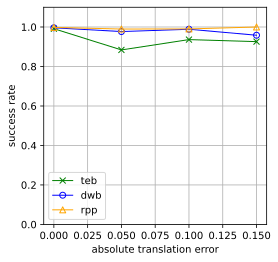

# 10 <= df.trajectory_length < 20

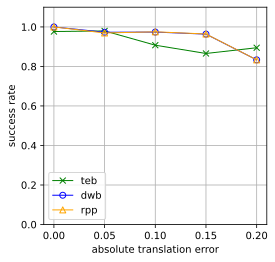

# 20 <= df.trajectory_length < 30

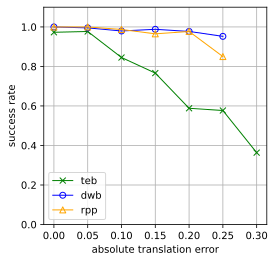

# 30 <= df.trajectory_length < 40

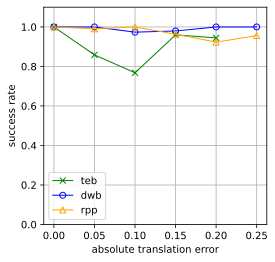

# 40 <= df.trajectory_length < 50

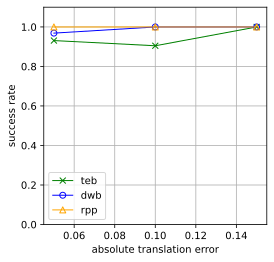

# 50 <= df.trajectory_length < 60

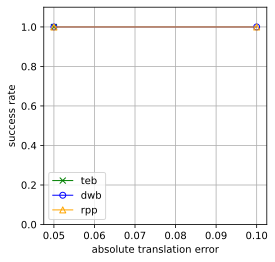

# 60 <= df.trajectory_length < 70

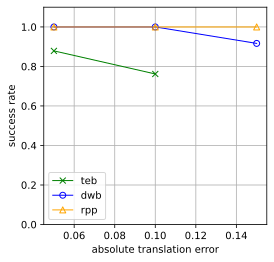

# 70 <= df.trajectory_length < 80

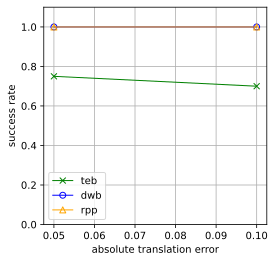

# 70 <= df.trajectory_length < 1000

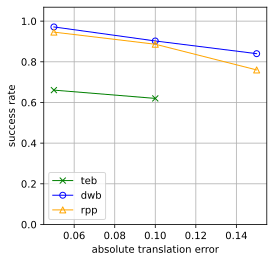

In [43]:

l_min_max = [
    [0, 10],
    [10, 20],
    [20, 30],
    [30, 40],
    [40, 50],
    [50, 60],
    [60, 70],
    [70, 80],
    [70, 1000],
]

for l_min, l_max in l_min_max:
    printmd(f"# {l_min} <= df.trajectory_length < {l_max}")
    d = df[(df.trajectory_length >= l_min) & (df.trajectory_length < l_max) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
#     printmd("# beta", beta)
#     d = df[(df.beta == beta) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner == 'navfn') & (df.localization == 'amcl')].copy()
    input_metrics, bin_widths = zip(*[
        [d.absolute_translation_error, 0.05],
#         [d.absolute_rotation_error, 0.01],
#         [d.relative_translation_error, 0.005],
#         [d.relative_rotation_error, 0.02],
    ])

#     printmd("## success_rate")
    plot_in_out_metrics_bin_width_save(
        output_metric=d.success_rate, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        min_y=0.0,
        plot_all=False,
        scatter=False,
        out_dir="thesis_plots/local_planner_by_trajectory_length",
    )
